# ResNet Model Building Pipeline for 1D Signals with DEMO
#### ResNet18, ResNet34, ResNet50, ResNet101, ResNet152

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [ ]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: Tesla P100-PCIE-16GB
GPU Capability: (6, 0)
Is GPU Initialized yet? True


# Connect to Google Drive (Optional for Google COLAB)

Copy-Paste the Authorization Code and Mount Google Drive to COLAB

In [1]:
from google.colab import drive
drive.mount('/content/GDrive')

Mounted at /content/GDrive


Move to the Target Directory

In [2]:
%cd /content/GDrive/MyDrive/Colab_Notebooks/GitHub/ResNet

/content/GDrive/MyDrive/Colab_Notebooks/GitHub/ResNet


List the Files and Folders Located in the Current Directory

In [3]:
!ls

 Drug_Persistency.xlsx	   ResNet_1DCNN.py		 SelfResNet.py
'Gender_H_W Dataset.csv'   ResNet_Implementation.ipynb	'SOCR Dataset.csv'
 __pycache__		   Saved_Model.h5		 VGG_1DCNN.py


Upload Files from Local Directory (if required)

In [ ]:
from google.colab import files
uploaded = files.upload()

#Import Necessary Libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, BatchNormalization, Activation, add
from keras.layers import Conv2D, MaxPooling2D, Reshape, Flatten, Dense
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
# Import ResNet1D Module
from ResNet_1DCNN import ResNet

# DEMO: Regression and Classification


## Regression

### Import and Prepare Dataset

Import Dataset from a CSV file using Pandas

In [70]:
dataset = pd.read_csv('Gender_H_W Dataset.csv')
print(dataset.shape)

(10000, 3)


Have a look at the dataset! The dataset contains Heights and Weights of 10000 people with their respective Gender. Either Height or Weight can be the target variable for Regression. The same dataset can also be used for Classification is someone wants to predict the gender based on respective Height and Weight.

In [71]:
dataset.head(10)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971111
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


Convert Text Data into Dummy Variables for Machine Learning. It is important since Machine Learning models will not accept string variables directly during training and testing.

In [72]:
dummy_dataset = pd.DataFrame()

In [73]:
for i in range(0,len(dataset.columns)):
  X = dataset[dataset.columns[i]]
  if type(X[0]) == str:
    Y = pd.get_dummies(X)
    dummy_dataset = pd.concat([dummy_dataset, Y], axis=1)
  else:
    dummy_dataset = pd.concat([dummy_dataset, X], axis=1)
#
dummy_dataset.shape

(10000, 4)

In [56]:
dummy_dataset['Height'] = dummy_dataset['Height']/100
dummy_dataset['Weight'] = dummy_dataset['Weight']/100

Now, Male and Female each have their separate columns (i.e., each are dummy variables). It is similar to One-Hot-Encoding done for Labels for Classification tasks.

In [74]:
dummy_dataset.head(10)

,Female,Male,Height,Weight
0,0,1,73.847017,241.893563
1,0,1,68.781904,162.310473
2,0,1,74.110105,212.740856
3,0,1,71.730978,220.042470
4,0,1,69.881796,206.349801
5,0,1,67.253016,152.212156
6,0,1,68.785081,183.927889
7,0,1,68.348516,167.971111
8,0,1,67.018950,175.929440
9,0,1,63.456494,156.399676


Convert Pandas DataFrame into NumPy Array using 'iloc'.

In [75]:
X_Data = dummy_dataset.iloc[:,0:-1].values # All columns except the last are the predicting variables
Y_Data = dummy_dataset.iloc[:,-1].values # Last column (Weight Column in this case) is the label
print(X_Data.shape)
print(Y_Data.shape)

(10000, 3)
(10000,)


Train-Test Split

In [76]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data, Y_Data, test_size=0.20, random_state=42)

The third axis is to show the number of channels, which is 1 in this case. If same labels were appropriate for more than 1 dataset, there would be more than 1 channel.

In [77]:
X_Train = np.expand_dims(X_Train, axis=2)
X_Test = np.expand_dims(X_Test, axis=2)

In [78]:
print(X_Train.shape, X_Test.shape)
print(Y_Train.shape, Y_Test.shape)

(8000, 3, 1) (2000, 3, 1)
(8000,) (2000,)


### Build and Train Imported Data using the ResNet based Regression Model

Configurations

In [88]:
"Configurations for ResNet in Regression Mode"
length = X_Train.shape[1]   # Number of Features (or length of the signal)
model_width = 128           # Number of Filter or Kernel in the Input Layer
num_channel = 1             # Number of Input Channels
problem_type = 'Regression' # Regression or Classification
output_number = 1           # Number of Outputs in the Regression Mode

Build Model

In [89]:
Regression_Model = ResNet(length, num_channel, model_width, problem_type=problem_type, output_nums=output_number).ResNet152() # Build Model
# ResNet Models supported: ResNet18, ResNet34, ResNet50, ResNet101, ResNet152, 
Regression_Model.compile(loss='mae', optimizer='adam', metrics= ['mse']) # Compile Model
# Here, Model validation metric is set as Mean Squared Error or MSE

Model_Summary

In [90]:
Regression_Model.summary() # Summary of the Model

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
conv1d_792 (Conv1D)             (None, 2, 128)       1024        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 1, 128)       0           conv1d_792[0][0]                 
__________________________________________________________________________________________________
conv1d_802 (Conv1D)             (None, 1, 128)       16512       max_pooling1d_4[0][0]            
____________________________________________________________________________________________

Upload Past Weights if available (Transfer Learning)

In [ ]:
Regression_Model.load_weights('Saved_Model.h5') # Load Previously Trained Weights for Transfer Learning

Train Model for 'n' number of Epochs with Batch size of 'm'

In [91]:
# Early Stopping and Model_Checkpoints are optional parameters
# Early Stopping is to stop the training based on certain condition set by the user
# Model Checkpoint is to save a model in a directory based on certain conditions so that it can be used later for Transfer Learning or avoiding retraining
callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min'), ModelCheckpoint('Saved_Model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = Regression_Model.fit(X_Train, Y_Train, epochs=500, batch_size=128, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)
# Save 'History' of the model for model performance analysis performed later

Epoch 1/500
50/50 [==============================] - 12s 79ms/step - loss: 110.3953 - mse: 14881.6306 - val_loss: 4003.0815 - val_mse: 16147564.0000

Epoch 00001: val_loss improved from inf to 4003.08154, saving model to Saved_Model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/500
50/50 [==============================] - 2s 40ms/step - loss: 15.5558 - mse: 395.2615 - val_loss: 4144.7173 - val_mse: 17404792.0000

Epoch 00002: val_loss did not improve from 4003.08154
Epoch 3/500
50/50 [==============================] - 2s 39ms/step - loss: 12.4203 - mse: 245.3937 - val_loss: 563.2961 - val_mse: 331952.2812

Epoch 00003: val_loss improved from 4003.08154 to 563.29614, saving model to Saved_Model.h5
Epoch 4/500
50/50 [==============================] - 2s 40ms/step - loss: 9.8877 - mse: 153.1769 - val_loss: 1423.7466 - val_mse: 2236476.0000

Epoch 00004: val_loss did not improve from 563.29614
Epoch 5/500
50/50 [==============================] - 2s 39ms/step - loss: 10.5106 - mse: 172.2290 - val_loss: 43.6442 - val_mse: 2092.8853

Epoch 00005: val_loss improved from 563.29614 to 43.64417, saving model to Saved_Model.h5
Epoch 6/500
50/50 [==============================] - 2s 39ms/step - loss: 9.9200 - mse: 156.2534 - val_loss: 89.1450 - val_mse: 12077.4570

Test and Predict

In [92]:
# Preictions from the Test Set from the Trained Model
Predictions = Regression_Model.predict(X_Test, verbose=1)
print(Predictions.shape)

63/63 [==============================] - 2s 10ms/step
(2000, 1)


Error Performance (Mean Sqaured Error or MAE)

In [93]:
# Error of the prediction, one of many evaluation metrics
# Using Mean Absolute Error (MAE) in this case as a sample
Error = mean_absolute_error(Y_Test, Predictions)
print(f"MAE: {Error}")

MAE: 24.016691516831454


Plot Train and Validation Error and Loss

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


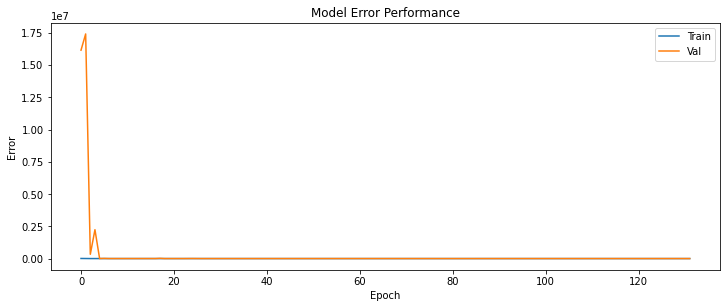

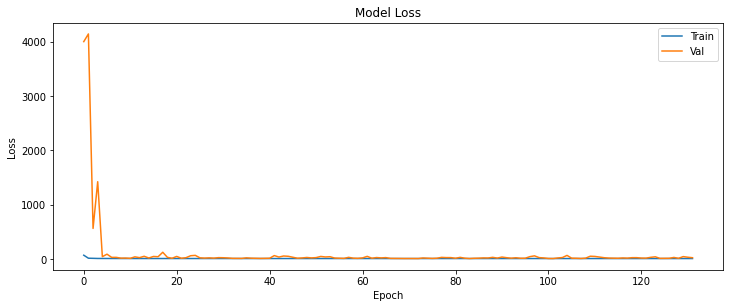

In [94]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Plot Prediction Performance

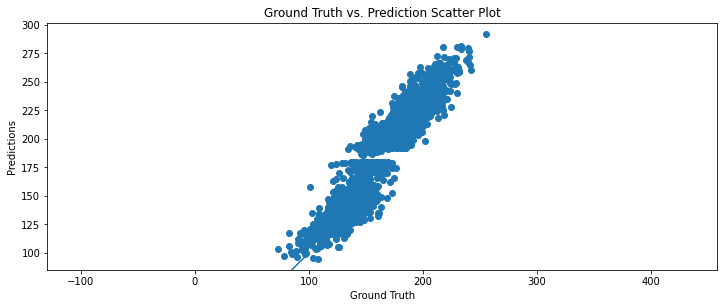

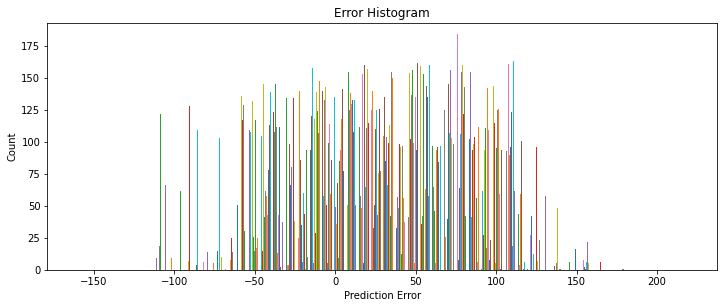

In [95]:
def plot_prediction(test_labels, test_predictions):
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.scatter(test_labels, test_predictions)
  plt.title('Ground Truth vs. Prediction Scatter Plot')
  plt.xlabel('Ground Truth')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  _ = plt.plot([-100, 100],[-100,100])
  #
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.title('Error Histogram')
  error = test_predictions - test_labels
  plt.hist(error, bins = 50)
  plt.xlabel("Prediction Error")
  _ = plt.ylabel("Count")
#
plot_prediction(Y_Test, Predictions)

You can perform futher analysis of the performance for potential improvement or even compare with other models. The dataset also can be preprocessed differently. For example, the model might have performed better if the values were normalized in the same way?

## Classification

### Data Preparation

Import the dataset from a CSV file and save it into a Pandas DataFrame

In [96]:
dataset = pd.read_excel('Drug_Persistency.xlsx', sheet_name = 'Dataset')
dataset.drop(columns=['Ptid'], inplace=True) # Drop Patient ID Column
print(dataset.shape)
dataset.head(10)

(3424, 68)


,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,Y,N,N,N,N,N,N,N,N,2
6,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,2,Y,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,N,N,Y,Y,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,Y,N,N,Y,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,1
7,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/

Create a Blank DataFrame

In [97]:
dummy_dataset = pd.DataFrame()

In [98]:
for i in range(0,len(dataset.columns)):
  X = dataset[dataset.columns[i]]
  if type(X[0]) == str:
    Y = pd.get_dummies(X)
    dummy_dataset = pd.concat([dummy_dataset, Y], axis=1)
  else:
    dummy_dataset = pd.concat([dummy_dataset, X], axis=1)
#
dummy_dataset.head(10)

,Non-Persistent,Persistent,Female,Male,African American,Asian,Caucasian,Other/Unknown,Hispanic,Not Hispanic,Unknown,Midwest,Northeast,Other/Unknown,South,West,55-65,65-75,<55,>75,CARDIOLOGY,CLINICAL NURSE SPECIALIST,EMERGENCY MEDICINE,ENDOCRINOLOGY,GASTROENTEROLOGY,GENERAL PRACTITIONER,GERIATRIC MEDICINE,HEMATOLOGY & ONCOLOGY,HOSPICE AND PALLIATIVE MEDICINE,HOSPITAL MEDICINE,NEPHROLOGY,NEUROLOGY,NUCLEAR MEDICINE,OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY,OBSTETRICS AND GYNECOLOGY,OCCUPATIONAL MEDICINE,ONCOLOGY,OPHTHALMOLOGY,ORTHOPEDIC SURGERY,ORTHOPEDICS,...,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,Count_Of_Risks
0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
2,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2
3,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
5,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2
6,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
7,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
8,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
9,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1


Convert the DataFrame to a Numpy Array

In [99]:
X_Data = dummy_dataset.iloc[:,0:-1].values
Y_Data = dummy_dataset.iloc[:,-1].values
print(X_Data.shape)
print(Y_Data.shape)

(3424, 182)
(3424,)


In [100]:
X_Train, X_Test, Y_Train_, Y_Test_ = train_test_split(X_Data, Y_Data, test_size=0.20, random_state=42)

One-Hot-Encoding for the Classification Labels

In [101]:
def one_hot_encoding(data):
  integer_encoded = LabelEncoder().fit_transform(data)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  one_hot_encoded_data = onehot_encoder.fit_transform(integer_encoded)
  return one_hot_encoded_data

In [102]:
Y_Train = one_hot_encoding(Y_Train_)
Y_Test = one_hot_encoding(Y_Test_)

Train and Test Data Shapes

In [103]:
print(X_Train.shape, X_Test.shape)
print(Y_Train.shape, Y_Test.shape)

(2739, 182) (685, 182)
(2739, 8) (685, 8)


### Build and Train Imported Data using the ResNet based Classification Model

Configurations

In [113]:
"Configurations for ResNet in Classification Mode"
length = X_Train.shape[1]       # Number of Features (or length of the signal)
model_width = 32                # Number of Input Channels
problem_type = 'Classification' # Regression or Classification
class_number = Y_Train.shape[1] # Number of Output Class in Classification Mode (>=2)

Build Model

In [114]:
Classification_Model = ResNet(length, num_channel, model_width, problem_type=problem_type, output_nums=class_number).ResNet152() # Change the ResNet Model if needed
if class_number == 2:
  Classification_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
elif class_number > 2:
  Classification_Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])

Model Summary

In [115]:
Classification_Model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 182, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_1188 (Conv1D)            (None, 91, 32)       256         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 45, 32)       0           conv1d_1188[0][0]                
__________________________________________________________________________________________________
conv1d_1198 (Conv1D)            (None, 45, 32)       1056        max_pooling1d_6[0][0]            
____________________________________________________________________________________________

Upload Past Weights (Transfer Learning)

In [ ]:
Classification_Model.load_weights('Saved_Classification_Model.h5') # Load Previously Trained Weights for Transfer Learning

Train Model

In [116]:
# Early Stopping and Model_Checkpoints are optional parameters
# Early Stopping is to stop the training based on certain condition set by the user
# Model Checkpoint is to save a model in a directory based on certain conditions so that it can be used later for Transfer Learning or avoiding retraining
callbacks = [EarlyStopping(monitor='val_loss', patience=50, mode='min'), ModelCheckpoint('Saved_Model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = Classification_Model.fit(X_Train, Y_Train, epochs=300, batch_size=64, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

Epoch 1/300
35/35 [==============================] - 11s 80ms/step - loss: 1.8749 - mse: 0.1016 - val_loss: 2.3296 - val_mse: 0.1189

Epoch 00001: val_loss improved from inf to 2.32964, saving model to Saved_Model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
35/35 [==============================] - 1s 23ms/step - loss: 0.8039 - mse: 0.0500 - val_loss: 2.3213 - val_mse: 0.0853

Epoch 00002: val_loss improved from 2.32964 to 2.32125, saving model to Saved_Model.h5
Epoch 3/300
35/35 [==============================] - 1s 22ms/step - loss: 0.5287 - mse: 0.0299 - val_loss: 1.1925 - val_mse: 0.0626

Epoch 00003: val_loss improved from 2.32125 to 1.19246, saving model to Saved_Model.h5
Epoch 4/300
35/35 [==============================] - 1s 22ms/step - loss: 0.3574 - mse: 0.0203 - val_loss: 1.2752 - val_mse: 0.0574

Epoch 00004: val_loss did not improve from 1.19246
Epoch 5/300
35/35 [==============================] - 1s 22ms/step - loss: 0.2556 - mse: 0.0139 - val_loss: 1.2416 - val_mse: 0.0672

Epoch 00005: val_loss did not improve from 1.19246
Epoch 6/300
35/35 [==============================] - 1s 22ms/step - loss: 0.3720 - mse: 0.0203 - val_loss: 1.8171 - val_mse: 0.0566

Epoch 00006: val_loss did not improve from 1.19246
Epoch 7/

Test

In [117]:
# Predictions from the Test Set from the Trained Model
Predictions = Classification_Model.predict(X_Test, verbose=1)
print(Predictions.shape)

22/22 [==============================] - 2s 8ms/step
(685, 8)


Error Performance

In [118]:
# Error of the prediction, one of many evaluation metrics
# Using Mean Absolute Error (MAE) in this case as a sample
Error = mean_absolute_error(Y_Test, Predictions)
print(f"MAE: {Error}")

MAE: 0.0032112621617213814


History

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


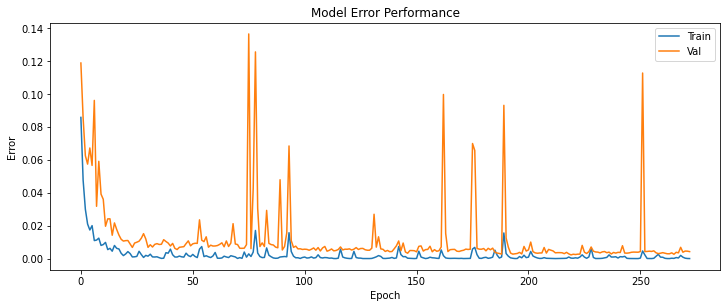

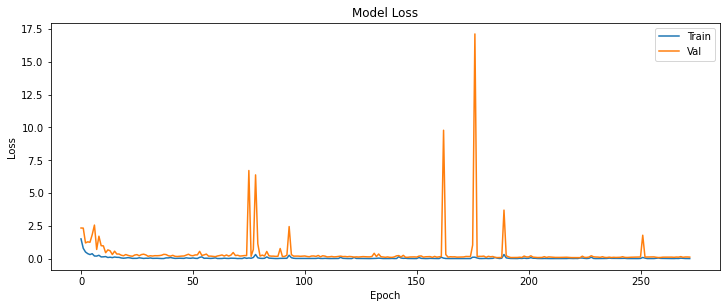

In [119]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Convert raw predictions into final, single-column, integer-based predictions

In [120]:
prediction_shape = Predictions.shape
prediction_length = prediction_shape[0]
Y_Labels = np.zeros((prediction_length, 1))
#
for i in range(0, prediction_length):
  prediction = Predictions[i]
  x = np.where(prediction == np.max(prediction))
  x = x[0]
  x = x.astype('int')
  Y_Labels[i] = x

Y_Labels.shape

(685, 1)

Plot Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

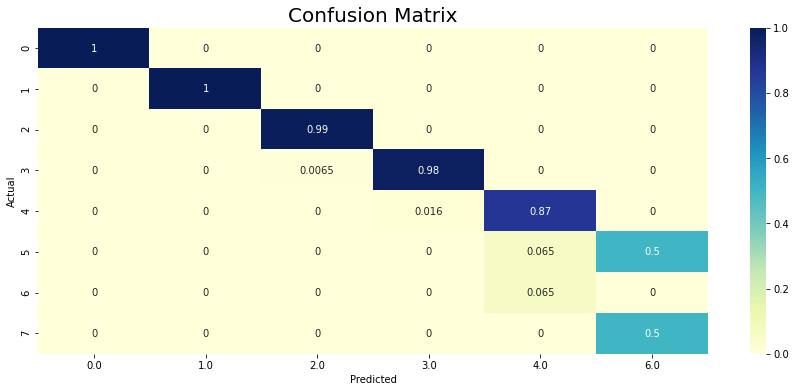

In [121]:
Conf = {'y_Actual': Y_Test_.ravel(), 'y_Predicted': Y_Labels.ravel()}
Conf = pd.DataFrame(data=Conf)
df_Conf_Mat = pd.DataFrame(Conf, columns=['y_Actual', 'y_Predicted'])
confusion_matrix = pd.crosstab(df_Conf_Mat['y_Actual'], df_Conf_Mat['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], normalize='columns')
plt.figure(figsize=(15, 6))
sns.heatmap(confusion_matrix, cmap='YlGnBu', annot=True)
plt.title('Confusion Matrix', fontsize=20)

Here it can be seen that risk level 5,6 and 7 could not be predicted well due to less number of instances.